In [25]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [26]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f'Value(data={self.data})'

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __radd__(self, other):
    return self + other

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other):
    return self * other

  def __truediv__(self, other):
    return self * (other**-1)

  def __pow__(self, other):
    assert isinstance(other, (int, float)), 'Only supporting int/float powers for now'
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad += other * (self.data**(other - 1)) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self,), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self,), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def backward(self):

    topo = []
    visited = set()

    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [27]:
# a / b
# a * (1/b)
# a * (b**-1)

In [28]:
a = Value(2.0)
b = Value(4)
b - a

Value(data=2.0)

In [29]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [30]:
# # inputs x1, x2
# x1 = Value(2.0, label='x1')
# x2 = Value(0.0, label='x2')
# # parameters w1, w2, b
# w1 = Value(-3.0, label='w1')
# w2 = Value(1.0, label='w2')
# b = Value(6.8813735870195432, label='b')

# x1w1 = x1 * w1; x1w1.label = 'x1*w1'
# x2w2 = x2 * w2; x2w2.label = 'x2*w2'
# x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
# n = x1w1x2w2 + b; n.label = 'n'
# o = n.tanh(); o.label = 'o'

In [31]:
# o.backward()
# draw_dot(o)

In [32]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# parameters w1, w2, b
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2 * n).exp()
o = (e - 1) / (e + 1); o.label = 'o'

o.backward()

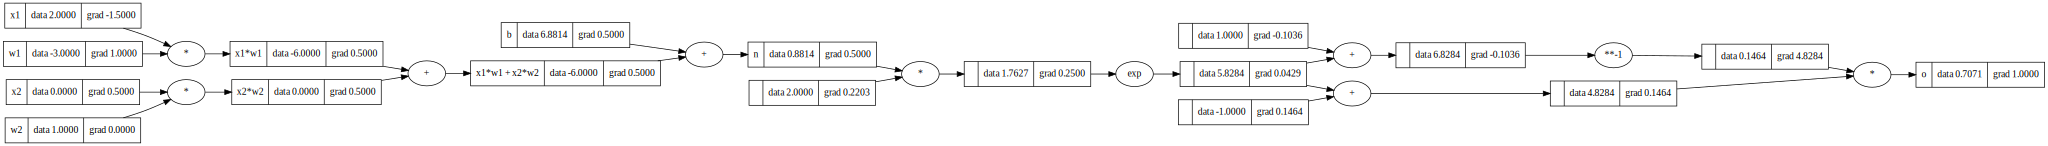

In [33]:
draw_dot(o)

In [34]:
import torch

In [35]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = w1*x1 + w2*x2 + b
o = torch.tanh(n)

print(o.item())
o.backward()

print('-' * 10)
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
----------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [36]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
      return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs

    def parameters(self):
      # return [p for neuron in self.neurons for p in neuron.parameters()]
      params = []
      for neuron in self.neurons:
        params.extend(neuron.parameters())
      return params

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x if len(x) > 1 else x[0]

    def parameters(self):
      return [p for layer in self.layers for p in layer.parameters()]

In [37]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
output = n(x)
print(output)

Value(data=-0.4592004017314817)


In [38]:
n.parameters()

[Value(data=0.36061758322450777),
 Value(data=-0.0612223381470014),
 Value(data=0.40092100358510896),
 Value(data=-0.02790571214872828),
 Value(data=0.2516263810225876),
 Value(data=-0.6330532107043501),
 Value(data=0.3477764671409367),
 Value(data=0.2028198965295862),
 Value(data=0.8748905839606018),
 Value(data=-0.576881999841258),
 Value(data=-0.9699366701626422),
 Value(data=-0.2984460970140064),
 Value(data=-0.9144330069706619),
 Value(data=-0.18448791533867692),
 Value(data=0.3730527784720856),
 Value(data=0.48175076009057904),
 Value(data=0.33574904412848805),
 Value(data=-0.22896201685031703),
 Value(data=0.8755062201880488),
 Value(data=-0.9017868046498456),
 Value(data=0.8156359195882972),
 Value(data=-0.18038236176059352),
 Value(data=0.41208475766708674),
 Value(data=0.137613126962854),
 Value(data=0.024675726157073807),
 Value(data=0.0005519043770798593),
 Value(data=-0.503880941228293),
 Value(data=-0.503019400334304),
 Value(data=-0.595375451817395),
 Value(data=0.000813

In [39]:
len(n.parameters())

41

In [40]:
n(x)

Value(data=-0.4592004017314817)

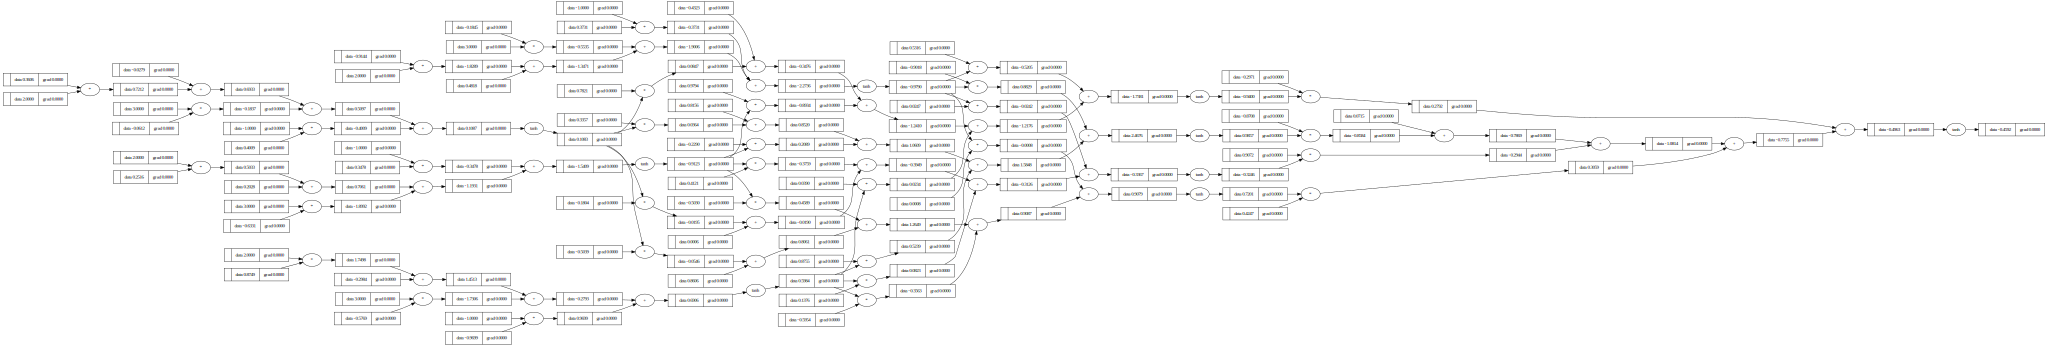

In [41]:
draw_dot(n(x))

In [42]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

In [43]:
# ypred = [n(x) for x in xs]
# ypred

In [44]:
# loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) / len(ys)
# loss

In [45]:
# loss.backward()

In [46]:
# n.layers[0].neurons[0].w[0].grad

In [47]:
# for p in n.parameters():
#   p.data -= 0.01 * p.grad

In [48]:
for i in range(1000):
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  for p in n.parameters():
    p.grad = 0.0

  loss.backward()

  for p in n.parameters():
    p.data -= 0.01 * p.grad

  print(i + 1, loss.data)

1 5.508330701776985
2 4.277698694223666
3 3.2052328858566694
4 2.46484750966753
5 1.9812641472826975
6 1.6375465538501044
7 1.3755622410277566
8 1.169692587528484
9 1.0058084481475544
10 0.8742015226196488
11 0.7675713019218793
12 0.6803340966840081
13 0.6082310778526692
14 0.5480240908287118
15 0.49724945826273925
16 0.45402489294761567
17 0.4169027143493318
18 0.38476041898363816
19 0.35671986860920396
20 0.33208776376154786
21 0.31031170983590595
22 0.2909476351276575
23 0.2736354692108415
24 0.25808085017782334
25 0.24404125508901253
26 0.23131539693375056
27 0.21973505161102275
28 0.20915870665711417
29 0.1994665865024277
30 0.1905567260574651
31 0.18234184888756244
32 0.17474686759246155
33 0.16770686888942954
34 0.16116547896603112
35 0.15507352920761291
36 0.14938796074599264
37 0.1440709200824826
38 0.1390890085037561
39 0.13441265599556929
40 0.13001559649425745
41 0.12587442605850346
42 0.12196822923270345
43 0.1182782617594748
44 0.11478768007002162
45 0.11148130977810869
4

In [51]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9774322375506536),
 Value(data=-0.9762801066055286),
 Value(data=-0.9712810968152568),
 Value(data=0.9690818040119046)]